# SECK Mouhamadou Abdoulaye
# abdouseck.tiv@gmail.com

## Projet detection de polarité de commentaire

L'objet de ce projet et de créer un modele capable d'identifier un commentaire négatif. C'est particulierement utile lorsque vous devez extraires des metrics de Qualité retour client sur de nombreuses pages de commentaires non labelisées (sans score).

Preparer un model d'analyse de sentiments
   - Nettoyage du corpus
   - Featurisation le texte (tf ou tf-idf)
   - Entrainer un modele de classification 0/1 (binaire) ou 0/1/2 (multiclass) 
   - Sauver votre model (pickle)
   - Tester votre model (prediction)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Les datasets sont deséquilibrés (beaucoup de commentaires positifs et peu de négatifs).

Dans ce cas d'usage, la ponctuation et certains caracteres spéciaux peuvent avoir leur importance. Les stop words "pas" "n'" peuvent egalement etre importants ("J'aime pas", "ne pas acheter ce produit", ...)

La lemmatization (conserver la racine du mot) et la stemmatisation (conserver le radical) ont une vrai utilité ici. En effet, il n'est pas necessaire de conserver certains combinaison de mots (filles et fille). Cela ne ferait qu'ajouter des colonnes semantiquement redondantes dans notre matrice BOW.

Commençons par regrouper nos datasets

In [2]:
# TBD
df=pd.read_csv('alexia_review.csv')
df.head()

,Unnamed: 0,Date,Note,Name,Comment
0,0,26 novembre 2018,1,Dewy,A savoir... Dès que vous donnez l'accès à vos ...
1,1,6 novembre 2018,3,Eric F.,"Du coté hardware, rien a redire, très bon appa..."
2,2,5 mai 2019,5,Sebastien,J’adore mon enceinte alexa elle fonctionne trè...
3,3,21 octobre 2018,4,quentin,En gros il y a vraiment du progrès en terme de...
4,4,22 octobre 2018,4,Coline Buchert,"Pas où peu d'instruction dans l'emballage, on ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   Date        5000 non-null   object
 2   Note        5000 non-null   int64 
 3   Name        5000 non-null   object
 4   Comment     5000 non-null   object
dtypes: int64(2), object(3)
memory usage: 195.4+ KB


#### Enlever les lignes redondantes

In [4]:
print(df.shape)
df.drop_duplicates('Comment',inplace=True)
print(df.shape)

(5000, 5)
(4916, 5)


Dispersion de la colonne Score :

In [5]:
df['Note'].value_counts()

5    3074
4     955
3     368
1     320
2     199
Name: Note, dtype: int64

#### Manipulation du texte

Fonction

1) Tokenisation



In [6]:
import re
from unidecode import unidecode


def tok_me(texte):
    # Je modifie la chaine de caractere s'il y a une ponctuation
    texte=texte.replace('.',' . ').replace('!', ' ! ').replace('?', ' ? ').replace('"', ' " ')
    p="([aA-zZéèàùîêâûôçïëœ.!?\"]{1,})"
    texte=' '.join(re.findall(p,texte))
    #Je renvoi une liste de token
    return texte.lower().split()


tok_me(df['Comment'].iloc[10])


['j',
 'ai',
 'attendu',
 'd',
 'avoir',
 'quelques',
 'jours',
 'de',
 'recul',
 'avant',
 'de',
 'poster',
 'cet',
 'article',
 'sur',
 'l',
 'écho',
 'dot',
 '.',
 'j',
 'avoue',
 'l',
 'avoir',
 'acheté',
 'sur',
 'un',
 'coup',
 'de',
 'tête',
 'à',
 'cause',
 'de',
 'son',
 'prix',
 'très',
 'bas',
 'et',
 'parce',
 'que',
 'j',
 'aime',
 'tous',
 'les',
 'gadgets',
 'technologiques',
 'efficace',
 'campagne',
 'promotionnelle',
 'd',
 'amazon',
 '!',
 '.',
 'je',
 'n',
 'y',
 'connais',
 'rien',
 'en',
 'assistants',
 'vocaux',
 'je',
 'viens',
 'juste',
 'de',
 'découvrir',
 'le',
 'ok',
 'google',
 'de',
 'mon',
 'smartphone',
 '.',
 '.',
 '.',
 'et',
 'c',
 'était',
 'une',
 'bonne',
 'occasion',
 'd',
 'essayer',
 '.',
 'ma',
 'maison',
 'n',
 'est',
 'pas',
 'du',
 'tout',
 'connectée',
 'c',
 'est',
 'pourquoi',
 'mon',
 'avis',
 'se',
 'limitera',
 'à',
 'l',
 'objet',
 'en',
 'lui',
 'même',
 'et',
 'à',
 'ses',
 'fonctionnalités',
 'internes',
 '.',
 'a',
 'première',
 


2) Reduction du nombre de token par rapprochement semantique

Fonction

- lemmatizer
- stemmer


On utiliser le fichier "lemmatize_fr.pickle" (dictionnaire sauvegardé en .pickle)

In [13]:
import pickle

with open('lemmatize_fr.pickle', 'rb') as f1:
    dico=pickle.load(f1)

dico

{'a': 'avoir',
 'a capella': 'a capella',
 'a cappella': 'a cappella',
 'a contrario': 'a contrario',
 'a fortiori': 'a fortiori',
 'a giorno': 'a giorno',
 'a jeun': 'à jeun',
 "a l'instar": "a l'instar",
 'a posteriori': 'a posteriori',
 'a priori': 'a priori',
 'aa': 'aa',
 'ab absurdo': 'ab absurdo',
 'ab initio': 'ab initio',
 'ab ovo': 'ab ovo',
 'abaca': 'abaca',
 'abaissa': 'abaisser',
 'abaissai': 'abaisser',
 'abaissaient': 'abaisser',
 'abaissait': 'abaisser',
 'abaissant': 'abaisser',
 'abaissante': 'abaissant',
 'abaisse': 'abaisser',
 'abaisse-langue': 'abaisse-langue',
 'abaissement': 'abaissement',
 'abaissent': 'abaisser',
 'abaisser': 'abaisser',
 'abaissera': 'abaisser',
 'abaisserai': 'abaisser',
 'abaisseraient': 'abaisser',
 'abaisserais': 'abaisser',
 'abaisserait': 'abaisser',
 'abaisses': 'abaisser',
 'abaissez': 'abaisser',
 'abaissons': 'abaisser',
 'abaissèrent': 'abaisser',
 'abaissé': 'abaissé',
 'abaissée': 'abaissé',
 'abaissées': 'abaissé',
 'abaissés':

In [14]:
def lem_me(tokens):
    final=[]
    for token in tokens:
        try:
            final.append(dico[token])
        except:
            final.append(token)
    return final

lem_me(tok_me(df['Comment'].iloc[0]))    

['avoir',
 'savoir',
 '.',
 '.',
 '.',
 'dès',
 'que',
 'vous',
 'donner',
 'l',
 'accès',
 'à',
 'vos',
 'contact',
 'par',
 'alexa',
 'elle',
 'vérifier',
 'automatiquement',
 'tout',
 'ceux',
 'qui',
 'avoir',
 'une',
 'echo',
 '.',
 'et',
 'du',
 'coup',
 'ces',
 'personnes',
 'pouvoir',
 'vous',
 'appeler',
 'à',
 'votre',
 'domicile',
 'sur',
 'votre',
 'echo',
 '.',
 '.',
 '.',
 '!',
 '!',
 '!',
 'si',
 'ce',
 'être',
 'des',
 'contact',
 'professionnel',
 'qui',
 'ne',
 'avoir',
 'pas',
 'à',
 'appeler',
 'à',
 'votre',
 'domicile',
 'ça',
 'devenir',
 'beaucoup',
 'moins',
 'sympa',
 '.',
 'et',
 'le',
 'plus',
 'rigolo',
 'c',
 'être',
 'que',
 'vous',
 'ne',
 'avoir',
 'aucun',
 'moyen',
 'de',
 'faire',
 'en',
 'sortir',
 'd',
 'être',
 'sur',
 'une',
 'liste',
 'rouge',
 '!',
 '!',
 '!',
 'il',
 'falloir',
 'éventuellement',
 'bloquer',
 'les',
 'contact',
 'un',
 'à',
 'un',
 '.',
 '.',
 '.',
 '.',
 'cela',
 'correspondre',
 'à',
 'une',
 'publication',
 'sur',
 'annuaire

3) Elimination des mots neutre

Fonction

- stop words 

Vous pouvez utiliser le fichier "stop-w_fr.txt"


In [15]:
with open('stop-w_fr.txt',"r",encoding='utf8') as f:
    stop=f.read().split('\n')
stop.remove('haut')
stop.remove('pas')
stop.remove('ne')
stop.remove('n')
stop.remove('ni')
stop.remove('peu')
stop.remove('bon')
stop.remove('très')
stop.remove('tres')
stop.remove('même')
stop.remove('fait')
stop.remove('début')
stop.remove('mais')
stop.remove('dès')
stop.remove('premier')
stop.remove('première')
stop.remove('plus')
stop.remove('aussi')
stop.remove('bien')
stop.remove('assez')
stop.remove('retour')
stop.remove('tout')
stop.remove('rien')

stop

['a',
 'abord',
 'absolument',
 'afin',
 'ah',
 'ai',
 'aie',
 'aient',
 'aies',
 'ailleurs',
 'ainsi',
 'ait',
 'allaient',
 'allo',
 'allons',
 'allô',
 'alors',
 'anterieur',
 'anterieure',
 'anterieures',
 'apres',
 'après',
 'as',
 'attendu',
 'au',
 'aucun',
 'aucune',
 'aucuns',
 'aujourd',
 "aujourd'hui",
 'aupres',
 'auquel',
 'aura',
 'aurai',
 'auraient',
 'aurais',
 'aurait',
 'auras',
 'aurez',
 'auriez',
 'aurions',
 'aurons',
 'auront',
 'autant',
 'autre',
 'autrefois',
 'autrement',
 'autres',
 'autrui',
 'aux',
 'auxquelles',
 'auxquels',
 'avaient',
 'avais',
 'avait',
 'avant',
 'avec',
 'avez',
 'aviez',
 'avions',
 'avoir',
 'avons',
 'ayant',
 'ayez',
 'ayons',
 'b',
 'bah',
 'bas',
 'basee',
 'bat',
 'beau',
 'beaucoup',
 'bigre',
 'boum',
 'bravo',
 'brrr',
 'c',
 'car',
 'ce',
 'ceci',
 'cela',
 'celle',
 'celle-ci',
 'celle-là',
 'celles',
 'celles-ci',
 'celles-là',
 'celui',
 'celui-ci',
 'celui-là',
 'celà',
 'cent',
 'cependant',
 'certain',
 'certaine',


In [16]:
stop=[unidecode(elem) for elem in stop]

def stop_me(liste_token):
    final=[]
    for token in liste_token:
        if unidecode(token) in stop:
            continue
        final.append(unidecode(token))
    return final


stop_me(lem_me(tok_me(df['Comment'].iloc[10])))


['jour',
 'recul',
 'poster',
 'article',
 'echo',
 'dot',
 '.',
 'avouer',
 'acheter',
 'coup',
 'tete',
 'causer',
 'prix',
 'tres',
 'aimer',
 'tout',
 'gadget',
 'technologique',
 'efficace',
 'campagne',
 'promotionnel',
 'amazon',
 '!',
 '.',
 'ne',
 'yu',
 'connaitre',
 'rien',
 'assistant',
 'vocal',
 'venir',
 'decouvrir',
 'ok',
 'google',
 'smartphone',
 '.',
 '.',
 '.',
 'bonne',
 'occasion',
 'essayer',
 '.',
 'maison',
 'ne',
 'pas',
 'tout',
 'connecter',
 'avis',
 'limiter',
 'objet',
 'luire',
 'fonctionnalites',
 'interne',
 '.',
 'premier',
 'vue',
 'objet',
 'facturer',
 'petit',
 'mignon',
 'tout',
 'poser',
 'partout',
 'proximite',
 'priser',
 '.',
 'rien',
 'voir',
 'halo',
 'lumineux',
 'allumer',
 'disant',
 '"',
 'alexa',
 '"',
 'impression',
 'poudlard',
 '!',
 'voix',
 'alexa',
 'tres',
 'agreable',
 'haut',
 'parleur',
 'assez',
 'impressionner',
 'petit',
 'objet',
 '.',
 'retour',
 'realite',
 'vrai',
 'galerer',
 'connecter',
 'objet',
 'magique',
 'wif

In [17]:
import spacy

nlp = spacy.load("fr_core_news_sm")

# Si le _md est trop "lourd"
#nlp = spacy.load("fr_core_news_sm")
doc = nlp(df['Comment'].iloc[10])

print('mot', 'racine')
print('############################""')
for token in doc:
    print(token.text, token.lemma_)

mot racine
############################""
J' je
ai avoir
attendu attendre
d' de
avoir avoir
quelques quelque
jours jour
de de
recul recul
avant avant
de de
poster poster
cet ce
article article
sur sur
l' le
écho écho
dot dot
3.J' 3.J'
avoue avoue
l' l'
avoir avoir
acheté acheter
sur sur
un un
coup coup
de de
tête tête
, ,
à à
cause cause
de de
son son
prix prix
très très
bas bas
, ,
et et
parce parce
que que
j' je
aime aime
tous tout
les le
gadgets gadget
technologiques technologique
( (
efficace efficace
campagne campagne
promotionnelle promotionnel
d' de
Amazon Amazon
! !
) )
. .
Je je
n' n'
y y
connais connaître
rien rien
en en
assistants assistant
vocaux vocal
( (
je je
viens venir
juste juste
de de
découvrir découvrir
le le
ok ok
google google
de de
mon mon
smartphone smartphone
... ...
) )
, ,
et et
c' ce
était être
une un
bonne bon
occasion occasion
d' de
essayer essayer
. .
Ma mon
maison maison
n' n'
est être
pas pas
du de
tout tout
connectée connectée
, ,
c' ce
est être
pourqu

#### Lemmatization // Facultatif : 

Ci dessous une autre technique de reduction de dimension de la taille du vocabulaire de notre corpus, la lemmatization. Prendre le radical du mot (ex : mangé ==> manger, ...)

Utiliser spacy https://spacy.io/usage/models

La traitement peut être long ...

In [18]:
import spacy

nlp = spacy.load("fr_core_news_sm")

# Si le _md est trop "lourd"
#nlp = spacy.load("fr_core_news_sm")
doc = nlp(df['Comment'].iloc[10])

print('mot', 'racine')
print('############################""')
for token in doc:
    print(token.text, token.lemma_)

mot racine
############################""
J' je
ai avoir
attendu attendre
d' de
avoir avoir
quelques quelque
jours jour
de de
recul recul
avant avant
de de
poster poster
cet ce
article article
sur sur
l' le
écho écho
dot dot
3.J' 3.J'
avoue avoue
l' l'
avoir avoir
acheté acheter
sur sur
un un
coup coup
de de
tête tête
, ,
à à
cause cause
de de
son son
prix prix
très très
bas bas
, ,
et et
parce parce
que que
j' je
aime aime
tous tout
les le
gadgets gadget
technologiques technologique
( (
efficace efficace
campagne campagne
promotionnelle promotionnel
d' de
Amazon Amazon
! !
) )
. .
Je je
n' n'
y y
connais connaître
rien rien
en en
assistants assistant
vocaux vocal
( (
je je
viens venir
juste juste
de de
découvrir découvrir
le le
ok ok
google google
de de
mon mon
smartphone smartphone
... ...
) )
, ,
et et
c' ce
était être
une un
bonne bon
occasion occasion
d' de
essayer essayer
. .
Ma mon
maison maison
n' n'
est être
pas pas
du de
tout tout
connectée connectée
, ,
c' ce
est être
pourqu

En utilisant les modeles préentrainés de spacy (librairie NLP Python), nous pouvons manipuler un lemmatizer suffisamment performant pour la langue française.

#### Fonction de nettoyage

Nous reprenons nos trois fonctions et renvoyons une chaine de caractere

In [19]:
#TBD

def nettoyage(chaine):
    return ' '.join(stop_me(lem_me(tok_me(chaine))))


nettoyage(df['Comment'].loc[45])

'. objet changer vie falloir . possibilite maison entierement connecter presque . camer surveillance radiateur volet rouler eclairage pouvoir faire fonctionner electro menager . associe ampoule huer phillips top ! ambiance cosy dynamique personnalise soiree ! vrai boiter nuit ultra polyvalent final prix eleve appareil voir completement justifier . attention yu affairer faire solder produit lancement switch phillips euro presque arnaquer . euro minuter tutos net donner bon coup jeune vieux volet roulant . pouvoir faire home cinema fire stick tv incroyable aussi ! moitie box tv android tout plus pratiquer . ecouter musiquer multiroom . honnetement tres sympa echo dot gen . liste exhaustif posseder fonctionnalites ne servir pas manquer utilite divertissement utilite pratiquer marmiton echo show pas super adapter . . engendrer frustration extreme vecu acquisition tout eco systeme cite plus haut reconnaissance vocal hasardeux titrer morceau musiquer langue courante causer anglissismes ne sa

Application sur la colonne entiere

In [20]:
df['Clean_comment']=df['Comment'].apply(nettoyage)
df.head()

,Unnamed: 0,Date,Note,Name,Comment,Clean_comment
0,0,26 novembre 2018,1,Dewy,A savoir... Dès que vous donnez l'accès à vos ...,savoir . . . donner acces contact alexa verifi...
1,1,6 novembre 2018,3,Eric F.,"Du coté hardware, rien a redire, très bon appa...",cote hardware rien redire tres bon appareil tr...
2,2,5 mai 2019,5,Sebastien,J’adore mon enceinte alexa elle fonctionne trè...,adorer enceinte alexa fonctionner tres bien ma...
3,3,21 octobre 2018,4,quentin,En gros il y a vraiment du progrès en terme de...,gros yu vraiment progres terme design enceinte...
4,4,22 octobre 2018,4,Coline Buchert,"Pas où peu d'instruction dans l'emballage, on ...",pas peu instruction emballage recevoir aider c...


Conservons les commentaires suffisamment longs (plus de mots ==> plus de feature pour aider notre futur classifieur)

Par exemple, au moins 5 mots

In [21]:
def l_str(chaine):
    return len(chaine.split(' '))

df['len_comment']=df['Clean_comment'].apply(l_str)
df.head()

,Unnamed: 0,Date,Note,Name,Comment,Clean_comment,len_comment
0,0,26 novembre 2018,1,Dewy,A savoir... Dès que vous donnez l'accès à vos ...,savoir . . . donner acces contact alexa verifi...,92
1,1,6 novembre 2018,3,Eric F.,"Du coté hardware, rien a redire, très bon appa...",cote hardware rien redire tres bon appareil tr...,72
2,2,5 mai 2019,5,Sebastien,J’adore mon enceinte alexa elle fonctionne trè...,adorer enceinte alexa fonctionner tres bien ma...,32
3,3,21 octobre 2018,4,quentin,En gros il y a vraiment du progrès en terme de...,gros yu vraiment progres terme design enceinte...,65
4,4,22 octobre 2018,4,Coline Buchert,"Pas où peu d'instruction dans l'emballage, on ...",pas peu instruction emballage recevoir aider c...,76


In [22]:
df['len_comment'].describe()

count    4916.000000
mean       25.378967
std        28.048617
min         1.000000
25%        10.000000
50%        18.000000
75%        31.000000
max       370.000000
Name: len_comment, dtype: float64

In [24]:
df=df[df['len_comment']>=5]
df.head()

,Unnamed: 0,Date,Note,Name,Comment,Clean_comment,len_comment
0,0,26 novembre 2018,1,Dewy,A savoir... Dès que vous donnez l'accès à vos ...,savoir . . . donner acces contact alexa verifi...,92
1,1,6 novembre 2018,3,Eric F.,"Du coté hardware, rien a redire, très bon appa...",cote hardware rien redire tres bon appareil tr...,72
2,2,5 mai 2019,5,Sebastien,J’adore mon enceinte alexa elle fonctionne trè...,adorer enceinte alexa fonctionner tres bien ma...,32
3,3,21 octobre 2018,4,quentin,En gros il y a vraiment du progrès en terme de...,gros yu vraiment progres terme design enceinte...,65
4,4,22 octobre 2018,4,Coline Buchert,"Pas où peu d'instruction dans l'emballage, on ...",pas peu instruction emballage recevoir aider c...,76


In [25]:
#TBD
df['Note'].value_counts()

5    2686
4     896
3     355
1     310
2     195
Name: Note, dtype: int64

Equilibrer les classes (autant de 0 que de 1)

- Binarisation sur une nouvelle colonne (Note binaire)
       > 3 ==> label 1
       < 3 ==> label 0

In [26]:
df=df[df['Note']!=3]
df['bin_note']=(df['Note']> 3).astype(int)
df['bin_note'].value_counts()

1    3582
0     505
Name: bin_note, dtype: int64

In [27]:
df[df['bin_note']==1].sample(df['bin_note'].value_counts()[0])
df[df['bin_note']==0]

,Unnamed: 0,Date,Note,Name,Comment,Clean_comment,len_comment,bin_note
0,0,26 novembre 2018,1,Dewy,A savoir... Dès que vous donnez l'accès à vos ...,savoir . . . donner acces contact alexa verifi...,92,0
11,11,11 mai 2019,1,Un bon client,"J'ai fait plusieurs tests, et je me suis rendu...",fait test rendu compter media vrai amazon ecou...,107,0
15,15,10 novembre 2018,1,Hervé,L'application est juste HORRIBLE ! je possède ...,application horrible ! posseder huawei pro tot...,18,0
17,17,13 avril 2019,1,lahaye philippe,bonjourje viens d apprendre qu alexa est...,bonjourje venir apprendre alexa train ecouter ...,41,0
18,18,5 décembre 2018,1,SM,"Assez décu d'Alexa en genéral. Premièrement, i...",assez decu alexa general . falloir inscrit fra...,132,0
...,...,...,...,...,...,...,...,...
4945,4945,8 juillet 2019,1,Client d'Amazon,cet article présenté dans une pub à la télé pa...,article presenter pub tele parer simple utilis...,31,0
4968,4968,6 décembre 2018,1,Kalou,Je suis très déçu a du mal à comprendre quand ...,tres decu mal comprendre luire demander chose ...,16,0
4990,4990,4 février 2020,1,Zamek-67,Je ne peux malheureusement pas utiliser cet Ec...,ne pouvoir malheureusement pas utiliser echo d...,22,0
4993,4993,17 mai 2019,1,trebor,"mauvaise audition, ne connais rien et pas capa...",mauvais audition ne connaitre rien pas capable...,28,0


In [28]:
df_final=pd.concat([df[df['bin_note']==1].sample(df['bin_note'].value_counts()[0]),df[df['bin_note']==0]])

df_final['bin_note'].value_counts()

1    505
0    505
Name: bin_note, dtype: int64

In [29]:
df_final.sample(30)

,Unnamed: 0,Date,Note,Name,Comment,Clean_comment,len_comment,bin_note
1418,1418,2 janvier 2020,5,Mafalda,Éco alexa top reconnais bien la voix réponds à...,co alexa top reconnaitre bien voix repondre de...,21,1
150,150,22 janvier 2022,2,Yoh,Quelle déception. J'ai un Google Nest mini et ...,deception . google nest mini vouloir tester al...,102,0
4532,4532,28 mai 2019,5,RGR,"Bonne expérience, bon son et surpris de sa cap...",bonne experience bon surpris capacite repondre...,7,1
3628,3628,4 décembre 2019,5,Dadou,"J’aime bien, bon appareil, fonctionne bien, co...",aimer bien bon appareil fonctionner bien compr...,14,1
1475,1475,15 août 2020,5,Client d'Amazon,Sympa avoir une enceinte à pouvoir échanger av...,sympa enceinte pouvoir echanger simple aussi t...,13,1
4516,4516,26 janvier 2020,1,gerard buol,Elle est pas suis bien que long dit pour mous...,pas bien long mou elleces pas,6,0
3940,3940,20 septembre 2019,1,michael marie-sainte,"Qualité sonore médiocre, ne peux malheureuse...",qualite sonore mediocre ne pouvoir malheureuse...,21,0
2411,2411,17 janvier 2020,2,nindiana,Difficile de mettre en relation 3 écho pour 3 ...,difficile mettre relation echo oppose mais,6,0
2967,2967,19 septembre 2019,5,Florence,Reçu très rapidement. Mise en route très faci...,recu tres rapidement . miser route tres facile...,33,1
3957,3957,27 décembre 2019,2,andruetan,"Il s'agit d'un cadeau de Noël, qui ne marche p...",agir cadeau noel ne marcher pas impossible met...,9,0


In [30]:
df_final.sample(30)

,Unnamed: 0,Date,Note,Name,Comment,Clean_comment,len_comment,bin_note
861,861,4 juin 2020,1,petshop' fan,tout allait bien sauf que depuis 15 jours elle...,tout aller bien jour couper chanson milieu deb...,38,0
2180,2180,4 décembre 2019,5,poutard83,Évolution progressive des echo dot qui s’améli...,volution progressif echo dot ameliorer version...,14,1
2639,2639,26 janvier 2019,5,Ctophe,J'ai eu la chance de pouvoir tester l'amazon é...,chance pouvoir tester amazon echo dot google h...,33,1
2614,2614,2 décembre 2021,5,Tonton Jah,"Bon produit, conforme à la description.",bon produit conformer description .,5,1
3654,3654,14 mars 2022,2,LeChose,Encore rien compris à la domotique malgré mes ...,rien domotique tentative . . . gros tete profe...,10,0
2813,2813,7 décembre 2019,1,simipi,"jusqu’à maintenant, j'avais acheté plusieurs é...",maintenir acheter echo dot griser acheter coul...,19,0
1537,1537,3 novembre 2021,5,Rach'elle,"Le produit est super, il reconnaît bien la voi...",produit super reconnaitre bien voix comprendre...,18,1
2085,2085,19 décembre 2020,5,Mélanie,incompatible avec les 3/4 de les appareils alo...,incompatible appareil acheter amazon . musique...,25,1
519,519,22 janvier 2020,2,Didier,"Après bientôt deux mois d'utilisation, je trou...",bientot mois utilisation trouver version bien ...,44,0
4167,4167,10 septembre 2019,1,Blondiau,Ce produit déjà utilisé chez des amis chez moi...,produit utilise ami impossible connecter malgr...,10,0


### Entrainer un modele de classification


Pour entrainer un modele de Machine learning, il nous faut des variables et une cible (resultat).

Dans notre cas,  sont les commentaires et la cible le label de polarité de sentiment (0/1)

Les modeles statistiques vu au precedent Projet, sont utiles pour transformer chaque commentaire en ligne de score où chaque score est la valeur d'un Tf-IDF associée à une colonne (1-gram=1mot ou 2-gram=2mots adjacents, ...).

![title](https://image.ibb.co/gOmaP9/Capture.jpg)




Nous obtenons alors une matrice (C)BOW que nous appellerons X et la colonne score que nous appellerons y

X=[w1,...wn]   et  y  = ['sentiment']

    Creer votre matrice de feature (X) en utilisant une featurisation de votre corpus par tfidf

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(df_final['Clean_comment'])
X = vectorizer_tfidf.transform(df_final['Clean_comment'])


X_final=pd.DataFrame(X.toarray(),columns=vectorizer_tfidf.get_feature_names())


X_final

,abandonne,abandonner,aberrer,abonement,abonn,abonne,abonnement,abonner,abordable,aborde,...,ya,yamaha,years,you,youtube,yu,ze,zero,zigbee,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.166616,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.120660,0.0,0.0,0.0,0.0


X avait été défini comme la matrice TFIDF, c'est notre matrice de feature le score de chaque mot du corpus
dans chacun de ses éléments (les commentaires)

X . W = y

X . W = ŷ + epsilon



==> Determination X et y

In [45]:
X=X_final
y=df_final['bin_note']
y

4827    1
1738    1
4088    1
2291    1
538     1
       ..
4945    0
4968    0
4990    0
4993    0
4998    0
Name: bin_note, Length: 1010, dtype: int32

Train test split

In [46]:
# TBD
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

Entrainons un modele via un solver de type Logistic Regression 

In [47]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8366336633663366


Pour evaluer, plus en detail la précision du modele, utilisons une matrice de confusion.
Elle permet de visualiser rapidement le nombre d'éléments mal predits


Vous obtiendrez en colonne les valeurs réelles (0 , 1). Et en ligne, les valeurs predites (0 , 1). Maximiser les éléments sur la digonale est notre objectif (bon match prediction reel)


In [48]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,clf.predict(X_test)).T

array([[87, 25],
       [ 8, 82]], dtype=int64)

En classification binaire, nous pouvons definir chacune des cases de ce tableau

![title](https://miro.medium.com/max/1890/1*OhEnS-T54Cz0YSTl_c3Dwg.jpeg)


    nb: Attention sur ce sch"ma les colonne et lignes sont inversées vs sklearn

Nous définissons deux indicateurs principaux pour évaluer un classifier

![title](https://miro.medium.com/max/1199/1*7J08ekAwupLBegeUI8muHA.png)

Et enfin le F1 score qui synthetise sa performance

![title](https://miro.medium.com/max/761/1*T6kVUKxG_Z4V5Fm1UXhEIw.png)


In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84        95
           1       0.91      0.77      0.83       107

    accuracy                           0.84       202
   macro avg       0.84      0.84      0.84       202
weighted avg       0.85      0.84      0.84       202



#### Tester la perf de cette modelisation avec :

- LinearSVC()
- RandomForestClassifier()
- ComplementNB()


In [50]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
print(f"Train score : {clf.score(X_train, y_train)}")
print(f"Test score : {clf.score(X_test, y_test)}")
confusion_matrix(y_test,clf.predict(X_test)).T

Train score : 0.9938118811881188
Test score : 0.8663366336633663


array([[85, 17],
       [10, 90]], dtype=int64)

In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(f"Train score : {clf.score(X_train, y_train)}")
print(f"Test score : {clf.score(X_test, y_test)}")
confusion_matrix(y_test,clf.predict(X_test)).T

Train score : 1.0
Test score : 0.7821782178217822


array([[82, 31],
       [13, 76]], dtype=int64)

In [52]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
print(f"Train score : {clf.score(X_train, y_train)}")
print(f"Test score : {clf.score(X_test, y_test)}")
confusion_matrix(y_test,clf.predict(X_test)).T

Train score : 0.9566831683168316
Test score : 0.8613861386138614


array([[89, 22],
       [ 6, 85]], dtype=int64)

In [53]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(X_train, y_train)
print(f"Train score : {clf.score(X_train, y_train)}")
print(f"Test score : {clf.score(X_test, y_test)}")
confusion_matrix(y_test,clf.predict(X_test)).T

Train score : 0.9603960396039604
Test score : 0.8663366336633663


array([[89, 21],
       [ 6, 86]], dtype=int64)

#### Sauvegarde des modeles 

In [54]:
import pickle
pickle.dump(vectorizer_tfidf.vocabulary_,open("base.pkl","wb"))

pickle.dump(clf,open("clf.pkl","wb"))

#### Prediction 

In [55]:
# Chargement du classifier
clf=pickle.load(open("clf.pkl", "rb"))

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer
import numpy as np

# Je vous sollicite pour tester votre commentaire
commentaire=str(input())
commentaire=nettoyage(commentaire)
print(commentaire)



# Je prepare un TFIDF spécifique (le nouveau commentaire) avec le vocabulaire utilisé pour l'entrainement 
# du modele
vectorizer = TfidfVectorizer(decode_error="replace",vocabulary=pickle.load(open("base.pkl", "rb")))
tfidf = vectorizer.fit_transform(np.array([commentaire]))

# Je predispose des relances automatiques selon le resultat de la prediction 0 ou 1
d={0:"C'est pas super sympa ça comme commentaire", 1 : " Ok, donc, à priori, t'as plutot kiffé ce produit"}

# J'appel la mehode predict associé à notre nouvel objet clf (le classifier entrainé avec le meilleur score)
try:
    print(d[clf.predict(tfidf.toarray())[0]],clf.predict_proba(tfidf.toarray())[0])
except:
    print(d[clf.predict(tfidf.toarray())[0]])

j'aime bien
aimer bien
 Ok, donc, à priori, t'as plutot kiffé ce produit [0.33023657 0.66976343]


#### Reduction de dimension

Notre matrice X a plus de 1000 colonnes, certaines d'entre elles portent peut etre une information redondante avec une autre colonne feature.

Utilisons un technique de reduction de dimension pour recreer un Matrice X avec moins de colonne. Le Principal Components Analysis realise cette transformation et projetant notre matrice X sur une espace de plus petite dimension où les bases de cet espace sont un peu plus orthogonales (independantes)

Sur 500 dimensions par exemple

In [57]:
from sklearn.decomposition import PCA
# TBD
#pca = PCA(n_components=500)
pca = PCA()
X_red = pca.fit_transform(X)
X_red

array([[-1.78209352e-01, -1.08680096e-01, -2.60463860e-02, ...,
        -1.75336732e-03,  4.84591686e-03,  4.73102810e-17],
       [-1.42539757e-01, -5.71164131e-02,  2.32098248e-01, ...,
        -4.79895740e-03,  1.44088342e-03,  4.73102810e-17],
       [-5.94322548e-02,  3.22678523e-02,  1.25480283e-01, ...,
        -1.90488610e-03,  7.69456291e-04,  4.73102810e-17],
       ...,
       [ 3.37365551e-01, -5.58200552e-02, -6.54114837e-02, ...,
        -2.87871655e-04,  1.89336263e-03,  4.73102810e-17],
       [ 1.28393228e-01, -2.27990598e-02,  1.11189722e-02, ...,
         4.25213602e-04, -1.03154304e-03,  4.73102810e-17],
       [-8.97212233e-02, -4.50588190e-02, -6.59409875e-02, ...,
        -2.65052885e-04, -2.44084485e-04,  4.73102810e-17]])

In [58]:
print("nb colonnes initiales : ",X.shape[1])
print(f"nb colonnes réduit aprés l'ACP : {X_red.shape[1]}")
print(f"L'ACP a réussi à représenter {int(pca.explained_variance_ratio_.sum()*100)} % des données sur les {X_red.shape[1]} nouveaux axes" )
print(f"Grace à l'ACP on a réduit {X_red.shape[1]/X.shape[1] * 100} % du nombre de colonne initiale")

nb colonnes initiales :  3389
nb colonnes réduit aprés l'ACP : 1010
L'ACP a réussi à représenter 99 % des données sur les 1010 nouveaux axes
Grace à l'ACP on a réduit 29.802301563883148 % du nombre de colonne initiale


In [59]:
print(pca.singular_values_)

[3.61783278e+00 3.10882105e+00 3.02821492e+00 ... 1.57699778e-01
 1.39830199e-01 1.50354425e-15]


In [60]:
print(pca.explained_variance_ratio_)

[1.34940188e-02 9.96404728e-03 9.45404628e-03 ... 2.56393197e-05
 2.01579464e-05 2.33064840e-33]


In [61]:
def plot_variance_acp(fig, acp, X_acp, whis=1.5): 
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("", fontsize=35)
    ax.set_title("Percentage of explained variance \n on first components", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box=ax.boxplot(X_acp[:,0:10], whis=whis)
    ax.set_title("First components distributions", fontsize=20)

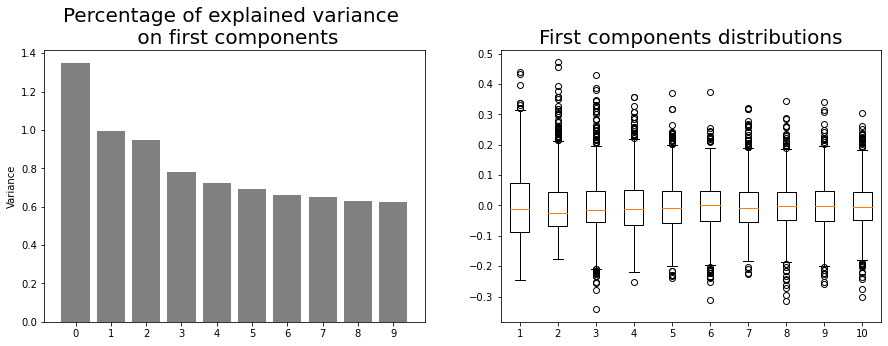

In [62]:
fig = plt.figure(figsize=(15,5))
plot_variance_acp(fig, pca, X_red, whis=1.5)

In [63]:
print(f"{pca.explained_variance_ratio_[0]*100} % des données ont été représenté sur la premiére axe (AXE 0)")
print(f"{pca.explained_variance_ratio_[1]*100} % des données ont été représenté sur la deuxiéme axe (AXE 1)")
print(f"On constate que les deux premiers axes expliquent {pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100} % des données")

1.3494018816200117 % des données ont été représenté sur la premiére axe (AXE 0)
0.9964047281223446 % des données ont été représenté sur la deuxiéme axe (AXE 1)
On constate que les deux premiers axes expliquent 2.345806609742356 % des données


**Je visualise nos données sur les 9 premiers nouveaux axes en 2D**

In [64]:
y_labels = []
for i in y:
    if i == 0:
        y_labels.append("Commentaire Negatif")
    else:
        y_labels.append("Commentaire Positif")

In [65]:
y_labels = []
for i in y:
    if i == 0:
        y_labels.append("Commentaire Negatif")
    else:
        y_labels.append("Commentaire Positif")

CMAP = plt.get_cmap("Set1")
LABEL_DIC = {0 : "Commentaire Negatif",
1 : "Commentaire Positif"}
y_label = ['Commentaire Negatif','Commentaire Positif']

COLOR_DIC = {v:CMAP(k-2) if v!="Commentaire Negatif" else CMAP(11) for k,v in LABEL_DIC.items()}
LABELS = [LABEL_DIC[c] for c in range(1)]
COLOR_LIST = [COLOR_DIC[l] for l in LABELS]
colors=[COLOR_DIC[yy] for yy in y_labels]
markersizes = [20 for yy in y]

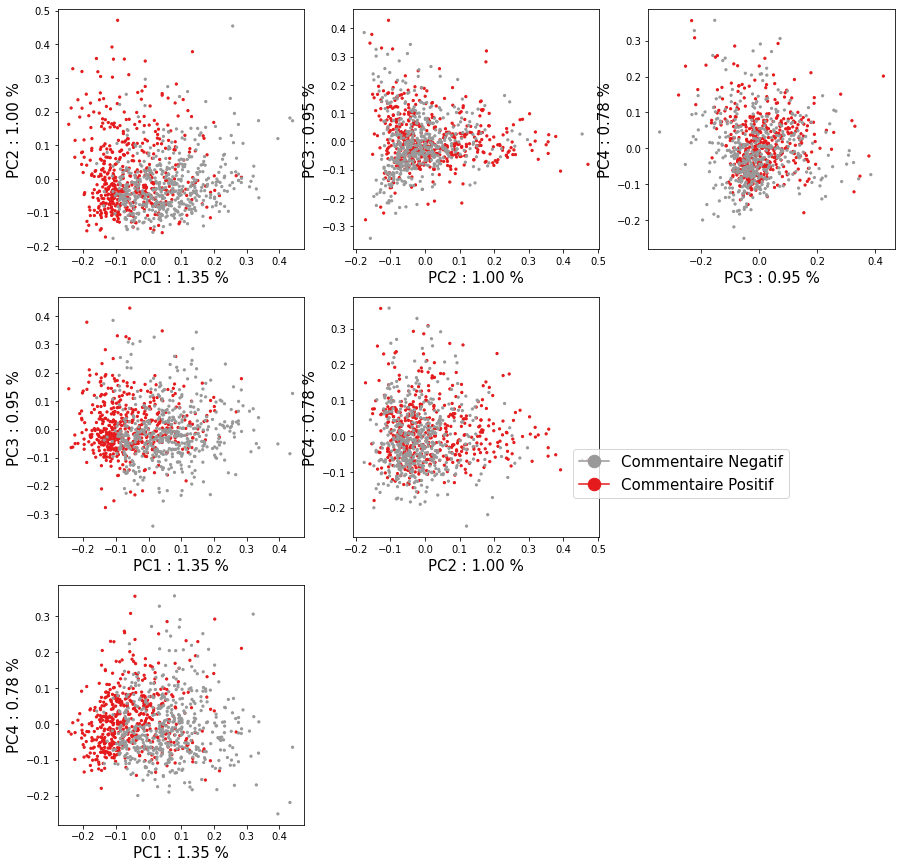

In [66]:
def plot_pca(ax, X, acp, nbc, nbc2, colors, markersizes):
    ax.scatter(X[:,nbc-1],X[:,nbc2-1],marker=".", color= colors, s=markersizes)
    ax.set_xlabel("PC%d : %.2f %%" %(nbc,acp.explained_variance_ratio_[nbc-1]*100), fontsize=15)
    ax.set_ylabel("PC%d : %.2f %%" %(nbc2,acp.explained_variance_ratio_[nbc2-1]*100), fontsize=15)

fig = plt.figure(figsize= (15,15))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(ax, X_red, pca, nbc, nbc2, colors, markersizes)

#Build legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=COLOR_DIC[act],marker=".", linestyle=None, markersize=25, label=act)for act in LABEL_DIC.values()]
plt.legend(handles=legend_elements,loc='upper right', bbox_to_anchor=(3, 1.6),fontsize=15)
plt.show()

Entrainer cette nouvelle modelisation avec un LinearSVC()


In [67]:
# TBD
from sklearn.model_selection import train_test_split

X_train_red, X_test_red, y_train, y_test = train_test_split(X_red,y,test_size=0.2)

In [68]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train_red, y_train)
print("Train score : ",clf.score(X_train_red, y_train))
print("Test score : ",clf.score(X_test_red, y_test))

Train score :  0.9938118811881188
Test score :  0.900990099009901


In [69]:
for i in df_final.Clean_comment:
    print(i)
    print("*****************************************************************************")

super ! famille adopte !
*****************************************************************************
pratiquer alexa ecouter musiquer station radio choses decouvrir . peu graver mais habituer . aimer
*****************************************************************************
tres fan servir pas mal truc reveil memo lumiere meteo info musiquer . . . . .
*****************************************************************************
top promo prix . excellent petit tailler . brancher enceindre existant plus puissant sortir mini jack
*****************************************************************************
appareil alexa garder caisson sub echo plus retourner inutilisable . alexa ne connait phraser enregistrer uniquement . echo dot bon rapport qualite prix bon . jbl go bluetooth . poster radio qualite reveil ? ? ! esperer ne plus deconnections wifi jour ? ! reussir journee radio rfm syncho stereo multi room maison mais falloir reconfigurer arret . . . . . .
*************************

parfait fait partir famille alexa
*****************************************************************************
fesait moment vouloir petit alexa maison grace superbe promo ! departir pas facile configurer mais patience obstination tout simplifier comprendre tout ! vraiment tout luire demander reponse tout ! top ami impressionner enceinte integre ! bonheur !
*****************************************************************************
retour anneesje ne vraiment pas decu produitsje ne vis plus alexa partager besoin
*****************************************************************************
marcher bien tres efficace taillemerci amazon permettre utiliser deezer spotifybien amazon music bien aussije recommander
*****************************************************************************
acheter curiosite maintenir utiliser tout temps . pouvoir commander tv lumieres ecouter musiquer . penser prendre meilleur .
****************************************************************************